In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
earliestdate = session.query(Measurement.date).order_by(Measurement.date).first()
mostrecentdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Most Recent Date: {mostrecentdate[0]}")

Most Recent Date: 2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

latestdate = dt.datetime.strptime(mostrecentdate[0], '%Y-%m-%d')
firstquerydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
firstquerydate

sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= firstquerydate).all()

rain = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
rain = rain.dropna(how='any') # clean up non value entries
rain = rain.sort_values(["Date"], ascending=True)
rain = rain.set_index("Date")
# rain.tail(25)
rain.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


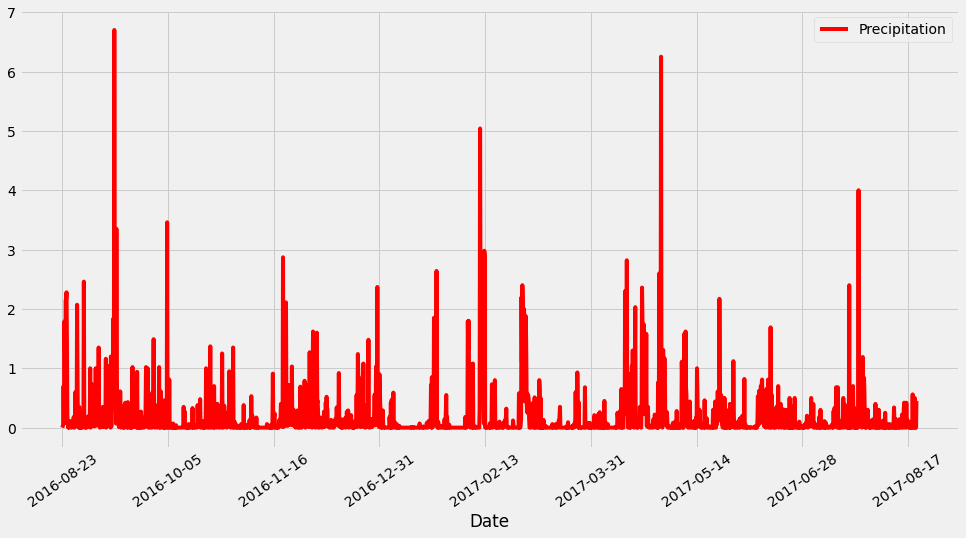

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data

rain.plot(color="red", rot=35,figsize=(15,7.5))
plt.savefig("Precipitation analysis.png")
plt.show()

# xx = rain.index.tolist()
# yy = rain['Precipitation'].tolist()

# X_Axis = np.arange(len(Date))
# tick_locations = [value for value in X_Axis]

# plt.figure(figsize=(15,7.5))
# plt.bar(xx,yy,width = 10 ,color= "pink", alpha=1, align="center",label='Precipitation')
# plt.tick_params(
#     axis='x',         
#     which='both',      
#     bottom=False,      
#     top=False,         
#     labelbottom=False) 
# major_ticks = np.arange(0,100,100)
# plt.xticks("date")

# plt.title(f"Precipitation from {firstquerydate} to {mostrecentdate[0]}")
# plt.xlabel('Date')
# plt.ylabel('Precipitation')
# plt.grid(which='major', axis='both', linestyle='-')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count() 

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
mostactivestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
mostactivestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactivestationinfo = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactivestationinfo

(54.0, 85.0, 71.66378066378067)

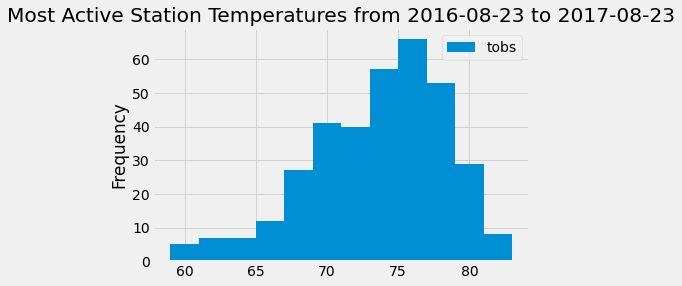

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == mostactivestations[0][0]).\
    filter(Measurement.date >= firstquerydate).all()
temps = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Lat','Long','Elevation'])

station = stations_desc.loc[stations_desc["Station"] == mostactivestations[0][0],"Name"].tolist()[0]

# plot
# plt.hist(temps, bins=12,rwidth=1.5,label={station})
plt.hist(temps,bins=12,rwidth=1.5,label='tobs')
plt.grid(axis='both', alpha=.8)
plt.ylabel('Frequency')
plt.title(f"Most Active Station Temperatures from {firstquerydate} to {mostrecentdate[0]}")
plt.legend()
plt.savefig("histogram.png")
# plt.tight_layout()


# Close session

In [18]:
# Close Session
session.close()